### DTW (台股上市Pair Trade)
#### 以DTW抓股票走勢相似度，在做配對交易
#### Workflow : DTW (抓平均交易量最大的N檔股票)/ DTW + Cointergration -> 抓配對 -> Z score (rolling) 當Threshold -> 訊號出現買賣(或者到下一個行程期的前一天賣出)

#### 都用收盤價進出場 (為還原收盤價)

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta 
from itertools import combinations
import warnings
from equity_plot import equity_plot
# from fastdtw import fastdtw
# from tqdm import tqdm
import matplotlib.pyplot as plt 
from statsmodels.tsa.stattools import coint, adfuller
import threading
warnings.filterwarnings("ignore")

C:\Users\USER\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
C:\Users\USER\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
C:\Users\USER\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,


![](https://i.imgur.com/a8syx02.png)

### Data

In [2]:
path = 'C:\\Users\\USER\\Python\\'

In [104]:
close = pd.read_pickle(path+'調整後收盤價.pkl')
volume = pd.read_pickle(path+'成交股數.pkl')/1000
industry = pd.read_pickle(path+'\\產業類別.pkl')
close = close.loc['2015-01-01':]
volume = volume.loc['2015-01-01':]

### Strategy

In [4]:
#換倉(3個月換一次，中間進行配對)
start_list = []
rebalance_day = 90
for x in range(len(close.index)) :
    if x%rebalance_day == 0:
        start_list.append(close.index[x])
        
end_list = []
for x in range(len(close.index)-(rebalance_day-1)) :
    if x%rebalance_day == 0:
        end_list.append(close.index[x+(rebalance_day-1)])

In [5]:
rebalance_list = {'start' : start_list[:len(end_list)],'end' : end_list}
pd.DataFrame(rebalance_list)

,start,end
0,2015-01-05,2015-05-22
1,2015-05-25,2015-10-01
2,2015-10-02,2016-02-16
3,2016-02-17,2016-06-28
4,2016-06-29,2016-11-08
5,2016-11-09,2017-03-24
6,2017-03-27,2017-08-03
7,2017-08-04,2017-12-11
8,2017-12-12,2018-04-30
9,2018-05-02,2018-09-05


### 算Distnace

In [117]:
# 1 : 單純只取距離最小的配對

pair_dic_1 = {}
volume_threshold = 200
pair = 200 # 每期形成期取前十對距離最小的配對
for i in range(len(rebalance_list['start'])) :
    
    start_date = rebalance_list['start'][i]
    end_date = rebalance_list['end'][i]
    
    stock_list = close.loc[start_date:end_date].dropna(axis = 1).columns # 去除形成期沒價格資料的股票
    top_volume = volume[stock_list].loc[start_date:end_date].dropna(axis = 1).mean().T.nlargest(volume_threshold).T.index #過濾交易量最大的前N支股票
    
    dist_dic = dtw_distance(close.loc[start_date:end_date],top_volume) # 依照DTW 算距離
    
    pair_dic_1[str(start_date)[0:10]] = pd.DataFrame(dist_dic,index = ['dist']).T.nsmallest(pair,columns = 'dist').index # 上一期找出來的配對標的會在下一期的Start運行策略
np.save('pair.npy',pair_dic_1)

100%|████████████████████████████████████████████████████████████████████████████| 19900/19900 [04:16<00:00, 77.69it/s]


In [115]:
# 2 : 算出距離後，挑選出coint p-value < 0.05的配對 在挑距離最近的前面10組

pair_dic = {}
volume_threshold = 200
pair = 200 # 每期形成期取前十對距離最小的配對
for i in range(len(rebalance_list['start'])) :
    
    start_date = rebalance_list['start'][i]
    end_date = rebalance_list['end'][i]

    stock_list = close.loc[start_date:end_date].dropna(axis = 1).columns # 去除形成期沒價格資料的股票
    top_volume = volume[stock_list].loc[start_date:end_date].dropna(axis = 1).mean().T.nlargest(volume_threshold).T.index #過濾交易量最大的前N支股票
    
    dist_dic , coint_dic= dtw_distance_coint(close.loc[start_date:end_date],top_volume) # 依照DTW 算距離
    
    coint_df = pd.DataFrame(coint_dic,index = ['coint']).T
    dist_df = pd.DataFrame(dist_dic,index = ['dist'])
    
    pair_dic[str(start_date)[0:10]] = dist_df[coint_df[coint_df['coint']<0.05].index].T.nsmallest(pair,columns = 'dist').index # 上一期找出來的配對標的會在下一期的Start運行策略
    
    del coint_df, dist_df

100%|████████████████████████████████████████████████████████████████████████████| 19900/19900 [09:38<00:00, 34.42it/s]


In [11]:
pair_coint = np.load('pair_coint.npy',allow_pickle = True).tolist()
pair_dtw = np.load('pair.npy',allow_pickle = True).tolist()

### Signal

In [31]:
pair_dic = pair_coint # DTW 挑完後再檢查共整合性
z_score_dic = {}
indicater_dic = {}
buy_short_dic = {}
exit_dic = {}
for i, date in enumerate(rebalance_list['start']) :
    if i < len(rebalance_list['start'])-1 :
        start_date = str(rebalance_list['start'][i+1])[0:10] # 進場日期
        z_score_dic[start_date] = z_score(pair_dic[str(date)[0:10]],i+1,10,last = False) # t期進場的標的 形成期為 t-1
        
    else : # 最近一次換倉
        start_date = str(rebalance_list['end'][-1]+timedelta(1))[0:10]
        z_score_dic[start_date] = z_score(pair_dic[str(date)[0:10]],i+1,10,last = True)
        
    indicater_dic[start_date] = z_score_dic[start_date].apply(lambda x : pd.cut(x,(float('-inf') ,-2,-0.5,0.5,2 ,float('inf')),labels=False))-2 # 指標
    
    buy_short_df = indicater_dic[start_date].apply(lambda x : np.select([(x.shift(-1) == 1) & # 建倉
                                                       (x == 2),
                                                       (x.shift(-1) == -1) & # 反向建倉
                                                       (x == -2)],[1,2],default = 0))
    buy_short_df = buy_short_df.shift(2) # 訊號出來的隔天建倉
    buy_short_dic[start_date] = buy_short_df

    exit_df = indicater_dic[start_date].apply(lambda x : np.select([(x.shift(-1) <= 0),
                                                       (x.shift(-1) >= 0)],[-1,-2],default = 0))
    
#     exit_df = indicater_dic[start_date].apply(lambda x : np.select([(x.shift(-1) <= 0)&
#                                                                     (x == 1),
#                                                        (x.shift(-1) >= 0)&
#                                                                    (x == -1)],[-1,-2],default = 0))
    
    exit_df = exit_df.shift(2)  # 訊號出來的隔天平倉.
    exit_dic[start_date] = exit_df

### Backtest

In [38]:
strategy_ret = {}
for enter_date in buy_short_dic.keys() :

    enter_date = enter_date
    total_pair_ret = pd.DataFrame(index =buy_short_dic[enter_date].index )
    for stock in buy_short_dic[enter_date].columns : # 配對標的迴圈

        test = buy_short_dic[enter_date][stock]
        test_exit = exit_dic[enter_date][stock]
        
        # fee = 0.001425*0.28*2 + 0.003  #雙邊手續費+稅
        fee = 0

        for i , date in enumerate(test.index) : # 計算配對交易報酬率
            pair2 = test.name[0:4] # 第一支股票
            pair1 = test.name[5:] # 第二支股票

            if test.loc[date] == 1 : # 建倉

                exit = test_exit[test_exit == -1].loc[date:] # 訊號產生後隔天平倉

                if len(exit) == 0 :
                    exit_day =  test.index[-1] # 最後一天出場
                else :
                    exit_day = exit.index[0]

                long_ret = close[pair2].loc[date:exit_day].pct_change().fillna(-fee) # 手續費
                short_ret = close[pair1].loc[date:exit_day].pct_change()*(-1)
                short_ret = short_ret.fillna(-fee)
                pair_ret = (long_ret+short_ret)/2
                total_pair_ret = pd.concat([total_pair_ret,pair_ret],axis = 1)

            if test.loc[date] == 2 : # 反向建倉

                exit = test_exit[test_exit == -2].loc[date:] # 訊號產生後隔天平倉

                if len(exit) == 0 :
                    exit_day = test.index[-1] # 最後一天出場
                else :
                    exit_day = exit.index[0]

                long_ret = close[pair1].loc[date:exit_day].pct_change().fillna(-fee) # 手續費
                short_ret = close[pair2].loc[date:exit_day].pct_change()*(-1)
                short_ret = short_ret.fillna(-fee)
                pair_ret = (long_ret+short_ret)/2
                total_pair_ret = pd.concat([total_pair_ret,pair_ret],axis = 1)

        total_ret = total_pair_ret.mean(axis = 1).fillna(0)
        strategy_ret[enter_date] = total_ret

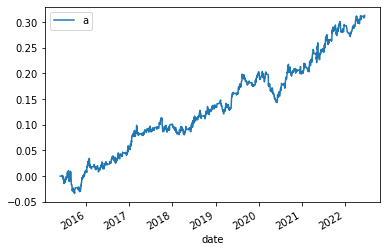

In [48]:
pd.DataFrame(strategy_ret.values()).T.mean(axis = 1).cumsum().plot()
plt.legend('a')

### 配對組數與報酬率之關係

In [55]:
pair_num = [1,5,10,50,100,150,200]
ret_dic = {}
for pair_n in pair_num :
    strategy_ret = {}
    for enter_date in buy_short_dic.keys() :

        enter_date = enter_date
        total_pair_ret = pd.DataFrame(index =buy_short_dic[enter_date].index )
        for stock in buy_short_dic[enter_date].columns[:pair_n] : # 配對標的迴圈

            test = buy_short_dic[enter_date][stock]
            test_exit = exit_dic[enter_date][stock]

            # fee = 0.001425*0.28*2 + 0.003  #雙邊手續費+稅
            fee = 0

            for i , date in enumerate(test.index) : # 計算配對交易報酬率
                pair2 = test.name[0:4] # 第一支股票
                pair1 = test.name[5:] # 第二支股票

                if test.loc[date] == 1 : # 建倉

                    exit = test_exit[test_exit == -1].loc[date:] # 訊號產生後隔天平倉

                    if len(exit) == 0 :
                        exit_day =  test.index[-1] # 最後一天出場
                    else :
                        exit_day = exit.index[0]

                    long_ret = close[pair2].loc[date:exit_day].pct_change().fillna(-fee) # 手續費
                    short_ret = close[pair1].loc[date:exit_day].pct_change()*(-1)
                    short_ret = short_ret.fillna(-fee)
                    pair_ret = (long_ret+short_ret)/2
                    total_pair_ret = pd.concat([total_pair_ret,pair_ret],axis = 1)

                if test.loc[date] == 2 : # 反向建倉

                    exit = test_exit[test_exit == -2].loc[date:] # 訊號產生後隔天平倉

                    if len(exit) == 0 :
                        exit_day = test.index[-1] # 最後一天出場
                    else :
                        exit_day = exit.index[0]

                    long_ret = close[pair1].loc[date:exit_day].pct_change().fillna(-fee) # 手續費
                    short_ret = close[pair2].loc[date:exit_day].pct_change()*(-1)
                    short_ret = short_ret.fillna(-fee)
                    pair_ret = (long_ret+short_ret)/2
                    total_pair_ret = pd.concat([total_pair_ret,pair_ret],axis = 1)

            total_ret = total_pair_ret.mean(axis = 1).fillna(0)
            strategy_ret[enter_date] = total_ret
            
    ret_dic[str(pair_n)] = pd.DataFrame(strategy_ret.values()).T.mean(axis = 1).cumsum()

<AxesSubplot:xlabel='date'>

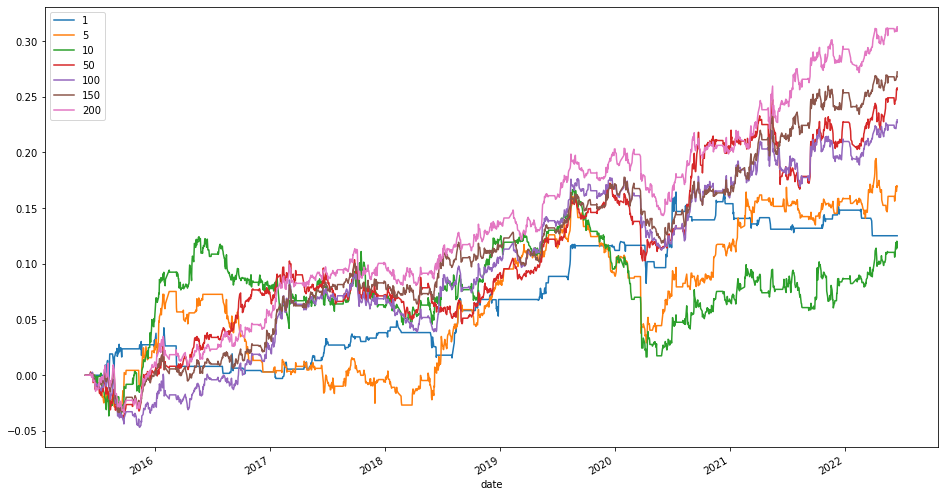

In [57]:
pd.DataFrame(ret_dic).plot(figsize = (16,9))

### 同產業配對

In [142]:
industry = pd.read_pickle(path+'\\產業類別.pkl')
industry.set_index('stock_id',inplace = True)

In [140]:
industry.產業類別.unique()

array(['水泥工業', '食品工業', '塑膠工業', '建材營造', '汽車工業', '其他', '紡織纖維', '貿易百貨',
       '電子零組件業', '電機機械', '生技醫療業', '電器電纜', '化學工業', '玻璃陶瓷', '造紙工業', '鋼鐵工業',
       '橡膠工業', '航運業', '電腦及週邊設備業', '半導體業', '其他電子業', '通信網路業', '光電業',
       '電子通路業', '資訊服務業', '油電燃氣業', '觀光事業', '金融保險業', '存託憑證'], dtype=object)

In [143]:
strategy_ret = {}
for enter_date in buy_short_dic.keys() :

    enter_date = enter_date
    total_pair_ret = pd.DataFrame(index =buy_short_dic[enter_date].index )
    for stock in buy_short_dic[enter_date].columns : # 配對標的迴圈

        test = buy_short_dic[enter_date][stock]
        test_exit = exit_dic[enter_date][stock]
        
        # fee = 0.001425*0.28*2 + 0.003  #雙邊手續費+稅
        fee = 0

        for i , date in enumerate(test.index) : # 計算配對交易報酬率
            pair2 = test.name[0:4] # 第一支股票
            pair1 = test.name[5:] # 第二支股票
            
            if industry.loc[pair2].values[0] == industry.loc[pair1].values[0] :
                
                if test.loc[date] == 1 : # 建倉

                    exit = test_exit[test_exit == -1].loc[date:] # 訊號產生後隔天平倉

                    if len(exit) == 0 :
                        exit_day =  test.index[-1] # 最後一天出場
                    else :
                        exit_day = exit.index[0]

                    long_ret = close[pair2].loc[date:exit_day].pct_change().fillna(-fee) # 手續費
                    short_ret = close[pair1].loc[date:exit_day].pct_change()*(-1)
                    short_ret = short_ret.fillna(-fee)
                    pair_ret = (long_ret+short_ret)/2
                    total_pair_ret = pd.concat([total_pair_ret,pair_ret],axis = 1)

                if test.loc[date] == 2 : # 反向建倉

                    exit = test_exit[test_exit == -2].loc[date:] # 訊號產生後隔天平倉

                    if len(exit) == 0 :
                        exit_day = test.index[-1] # 最後一天出場
                    else :
                        exit_day = exit.index[0]

                    long_ret = close[pair1].loc[date:exit_day].pct_change().fillna(-fee) # 手續費
                    short_ret = close[pair2].loc[date:exit_day].pct_change()*(-1)
                    short_ret = short_ret.fillna(-fee)
                    pair_ret = (long_ret+short_ret)/2
                    total_pair_ret = pd.concat([total_pair_ret,pair_ret],axis = 1)
            else :
                next
        total_ret = total_pair_ret.mean(axis = 1).fillna(0)
        strategy_ret[enter_date] = total_ret

KeyError: '2499'

In [95]:
industry.loc[pair1].values[0]

KeyError: '2847'

### Test

### Function

In [6]:
def dtw_distance_coint(df,stocks) :
    df = df[stocks]
    df = df.dropna(axis = 1) # 去除掉形成期沒資料的股票
    df_ret = df/df.head(1)
    
    dist_dic = {}
    coint_dic = {}
    pair_list = list(combinations(stocks,2)) # 配對的股票 (Cn取2)
    
    for stock in tqdm(pair_list) :     
        pair1 = stock[0]
        pair2 = stock[1] 
        
        distance, path = fastdtw(np.array(df_ret.loc[:,pair1].dropna()),
                                 np.array(df_ret.loc[:,pair2].dropna()))
        
        score, pvalue, _ = coint(df.loc[:,pair1],df.loc[:,pair2])
        
        dist_dic[pair1+'_'+pair2] = distance
        coint_dic[pair1+'_'+pair2] = pvalue

    return dist_dic , coint_dic

In [7]:
def dtw_distance(df,stocks) :
    df = df[stocks]
    df = df.dropna(axis = 1) # 去除掉形成期沒資料的股票
    df_ret = df/df.head(1)
    

    dist_dic = {}
    pair_list = list(combinations(stocks,2)) # 配對的股票 (Cn取2)
    
    for stock in tqdm(pair_list) :     
        pair1 = stock[0]
        pair2 = stock[1] 
    
        distance, path = fastdtw(np.array(df_ret.loc[:,pair1].dropna()),
                                 np.array(df_ret.loc[:,pair2].dropna()))
        
        dist_dic[pair1+'_'+pair2] = distance

    return dist_dic

In [8]:
def pair_calculate(date_list) :
    
    start_date = date_list[0]
    end_date = date_list[1]

    close_ret = close.loc[start_date:end_date]/close.loc[start_date:end_date].head(1) # 算累計報酬
    top_volume = volume.loc[start_date:end_date].mean().T.nlargest(volume_threshold).T.index #過濾交易量最大的前N支股票
    dist_dic = dtw_distance(close_ret.loc[start_date:end_date],top_volume) # 依照DTW 算距離
    
    pair_dic[str(start_date)[0:10]] = pd.DataFrame(dist_dic,index = ['dist']).T.nsmallest(pair,columns = 'dist').index # 上一期找出來的配對標的會在下一期的Start運行策略
    print('%s ~ %s 資料篩選/配對完畢, 共有%s 對組合' %(start_date,end_date,pd.DataFrame(dist_dic,index = ['dist']).shape[1]))
    # return pair_dic

In [9]:
def z_score(stock_pair_list,i,windows,last) : 
    
    if last == False :
        start = rebalance_list['start'][i]
        end = rebalance_list['end'][i]
    
    elif last == True :
        start = rebalance_list['end'][-1] + timedelta(1) #進場時間為形成期後一天
        end = close.index[-1] # 持有到最新一筆資料
        
    dic = {}
    
    for index , col in enumerate(stock_pair_list) :
        col1 = col[0:4]
        col2 = col[5:]

        ratio_df = close.loc[start:end][[col1,col2]]
        ratio = ratio_df[col1]/ratio_df[col2]
        ratio_sd = ratio.rolling(10).std()
        z_score = (ratio-ratio.rolling(10).mean())/ratio_sd
        dic[col] = z_score
        
    z_score_df = pd.DataFrame(dic)

    return z_score_df

In [10]:
def stationarity_test(X, cutoff=0.01):
    # H_0 in adfuller is unit root exists (non-stationary)
    # We must observe significant p-value to convince ourselves that the series is stationary
    pvalue = adfuller(X)[1]
    if pvalue < cutoff:
        print('p-value = ' + str(pvalue) + ' The series ' + X.name +' is likely stationary.')
    else:
        print('p-value = ' + str(pvalue) + ' The series ' + X.name +' is likely non-stationary.')

#### Test

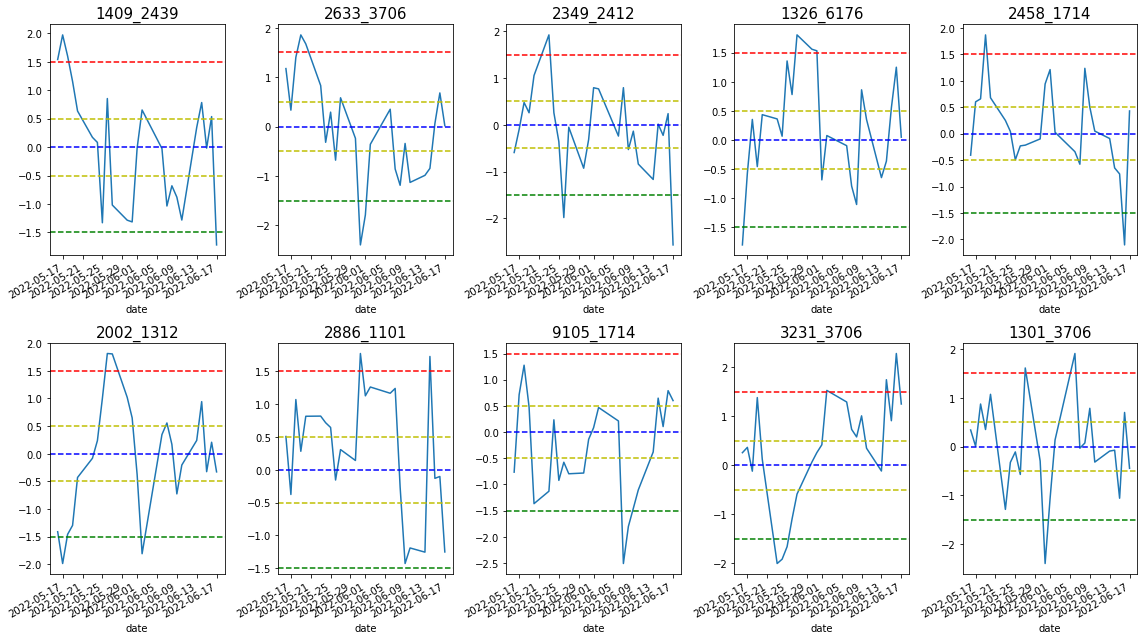

In [14]:
fig , axes = plt.subplots(int(pair/5),int(pair/2),figsize=(16,9))
axe = axes.ravel()
for i ,col_name in enumerate(dist_df.index) :
    ratio = test[col_name[0:4]]/test[col_name[5:]]
    ratio_sd = ratio.rolling(10).std()
    z_score = (ratio-ratio.rolling(10).mean())/ratio_sd
    
    z_score.plot(ax = axe[i])
    
    axe[i].set_title(col_name,fontsize = 15)
    # 開倉
    axe[i].axhline(1.5,color = 'r',linestyle = 'dashed') 
    axe[i].axhline(0,color = 'b',linestyle = 'dashed')
    axe[i].axhline(-1.5,color = 'g',linestyle = 'dashed')
    
    # 平倉
    axe[i].axhline(0.5,color = 'y',linestyle = 'dashed')
    axe[i].axhline(-0.5,color = 'y',linestyle = 'dashed')
    
    plt.tight_layout()

In [ ]:
# pair_dic = {}
volume_threshold = 200
pair = 10 # 每期形成期取前十對距離最小的配對

start = time.time()

if __name__ == "__main__":
    
    pool = Pool(8)
    pair_list = pool.map(pair_calculate.pair_calculate, rebalance_slice[0:1]) # 平行處理 (pair calculate 包成py檔 計算如下方func)
end = time.time()

print("執行時間：%f 秒" % (end - start))
    

<AxesSubplot:title={'center':'3231_3706'}, xlabel='date'>

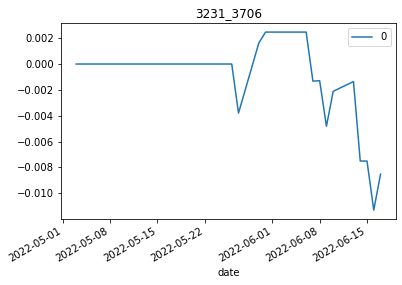

In [158]:
test = buy_short_df["3231_3706"]
test_exit = exit_df["3231_3706"]
ret_df = pd.DataFrame(index = test.index,columns = [0])
total_pair_ret = pd.DataFrame()
fee = 0.001425*0.28*2 + 0.003  #雙邊手續費+稅

for i , date in enumerate(test.index) :
    pair1 = test.name[0:4] # 第一支股票
    pair2 = test.name[5:] # 第二支股票

    if test.loc[date] == 1 : # 建倉

        exit = test_exit[test_exit == -1].loc[date:] # 訊號產生後隔天平倉

        if len(exit) == 0 :
            exit = test.index[-1] # 最後一天出場
        else :
            exit = exit.index[0]

        long_ret = close[pair2].loc[date:exit].pct_change().fillna(-fee) # 手續費
        short_ret = close[pair1].loc[date:exit].pct_change()*(-1)
        short_ret = short_ret.fillna(-fee)
        pair_ret = (long_ret+short_ret)/2
        total_pair_ret = pd.concat([total_pair_ret,pair_ret],axis = 0)

    if test.loc[date] == 2 : # 反向建倉

        exit = test_exit[test_exit == -2].loc[date:] # 訊號產生後隔天平倉

        if len(exit) == 0 : # 如果沒有出場訊號
            exit = test.index[-1] # 最後一天出場
        else :
            exit = exit.index[0]

        long_ret = close[pair1].loc[date:exit].pct_change().fillna(-fee) # 手續費
        short_ret = close[pair2].loc[date:exit].pct_change()*(-1)
        short_ret = short_ret.fillna(-fee)
        pair_ret = (long_ret+short_ret)/2
        total_pair_ret = pd.concat([total_pair_ret,pair_ret],axis = 0)

ret_df = ret_df.fillna(total_pair_ret).fillna(0)
ret_df.cumsum().plot(title = "3231_3706")